# Segmentation of cells/nuclei with [Cellpose](http://www.cellpose.org/) (Setup)

This notebook segments cell nuclei in each z-layer and combines them into a 3D mask.

Run this notebook cell-by-cell and follow the instructions.

#### Documentation

- [Cellpose documentation](https://cellpose.readthedocs.io/en/latest/)
- [Paper](https://www.biorxiv.org/content/10.1101/2020.02.02.931238v1)
- [Code](https://github.com/MouseLand/cellpose)

## Requirements
- A folder with images that should be segmented. All z-layers for a specific sample must be combined into a single file. To combine z-layers and channels, run [images_to_stack.ipynb](images_to_stack.ipynb).

<hr style="height:2px;">

## Config

<hr style="height:2px;">

### The following code imports and declares functions used for the processing:

In [1]:
#################################
#  Don't modify the code below  #
#################################

import os
import intake_io
import numpy as np
from skimage import io
import pylab as plt
from am_utils.utils import walk_dir
from cellpose import models, utils, plot, transforms
from punctatools.lib.segment import segment_cells
from punctatools.lib.utils import save_parameters

2022-01-18 17:39:10,444 [INFO] WRITING LOG OUTPUT TO /home/amedyukh/.cellpose/run.log


### Please provide data paths:

`input_dir`: folder with images of cells to be segmented

`output_dir`: folder to save results

In [2]:
input_dir = "../example_data/stacks"
output_dir = "../test_output/cells"

### The following code lists all image files in the input directory:

In [3]:
#################################
#  Don't modify the code below  #
#################################

samples = walk_dir(input_dir)

print(f'{len(samples)} images were found:')
print(np.array(samples))

2 images were found:
['../example_data/stacks/sample1_position1.tif'
 '../example_data/stacks/sample1_position2.tif']


### The following code loads a random image

In [4]:
#################################
#  Don't modify the code below  #
#################################

sample = samples[np.random.randint(len(samples))]
dataset = intake_io.imload(sample)
print(dataset, '\n')
if 'c' in dataset.dims:
    nchannels = len(dataset['c'].data)
    chnames = dataset['c'].data
else:
    nchannels = 1
    chnames = [0]
print(rf"Number of channels: {nchannels}")

<xarray.Dataset>
Dimensions:  (y: 326, x: 326, z: 5, c: 3)
Coordinates:
  * y        (y) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * x        (x) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * z        (z) float64 0.0 0.2 0.4 0.6 0.8
Dimensions without coordinates: c
Data variables:
    image    (c, z, y, x) uint16 111 114 120 143 172 158 ... 102 101 100 102 100
Attributes:
    metadata:  {'spacing_units': {}} 

Number of channels: 3


### Specify the channel index to segment

Channel index starts from 0

In [5]:
channel = 0

### The following code displays an example image

/research/sharedresources/cbi/public/conda_envs/punctatools/lib/python3.9/site-packages/scikit_image-0.19.0-py3.9-linux-x86_64.egg/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


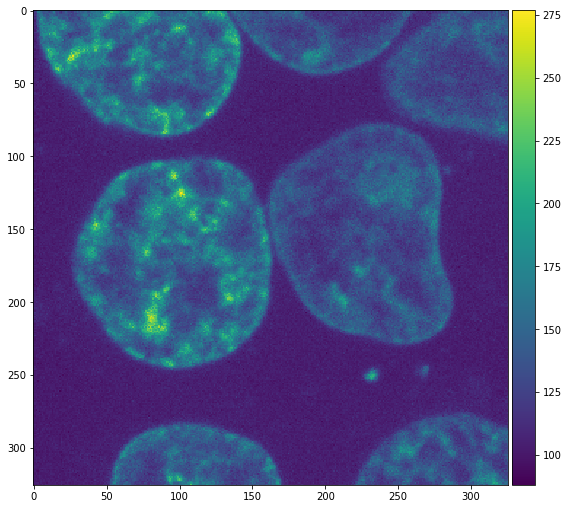

In [6]:
#################################
#  Don't modify the code below  #
#################################

if 'c' in dataset.dims:
    img = dataset.loc[dict(c=chnames[channel])]['image']
else:
    img = dataset['image']
if 'z' in dataset.dims:
    img = img.loc[dict(z=img['z'][int(len(img['z'])/2 - 0.5)])]
    
plt.figure(figsize=(8,8))
io.imshow(img.data)

### Please specify cell segmentation parameters

#### Cellpose parameters

`diameter`: average nucleus diameter in pixels; set to `None` to automatically detect the cell diameter

`model_type`: `nuclei` for nuclei segmentationm, `cyto` to segment cells 

`do_3D`: to perform segmentation in 3D set to `True`, to segment layer-by-layer set to `False`. If there is only one layer of cells, choose `False` since the 2D segmentation is faster

#### Other parameters

`remove_small_mode` : '2D', or '3D'. Used to remove small cells/nuclei by volume (3D) or area (2D). For a thin stack (as in the example data), use '2D'. (Default is '2D')

`remove_small_diam_fraction` : Minimal diameter for the cells/nuclei. Provided as a fraction of the target diameter (the `diameter` parameter). (Default is 0.5)


`clear_border` : If True, will remove cell touching image border (in xy only). (Default is False)

In [7]:
diameter = 120 
model_type = "cyto" # it seems like the "cyto" model works better for this dataset
do_3D = False

remove_small_mode = '2D'
remove_small_diam_fraction = 0.5
clear_border = False

### Advanced cellpose parameters:

`flow_threshold`: increase if model returns too few masks, decrease if model returns too many ill-shaped masks

`probability_threshold`:  decrease if model returns too few cells, increase if model returns too many cells  
Values should be between -6 and +6

`gpu`: set to `True` to use GPU, set to `False` to use CPU

In [8]:
flow_threshold = 0.4        # default: 0.4
cellprob_threshold = 0   # default: 0.0
gpu = True

### The following code segments the random image and displays the results:

2022-01-18 17:39:16,267 [INFO] ** TORCH CUDA version installed and working. **
2022-01-18 17:39:16,268 [INFO] >>>> using GPU
2022-01-18 17:39:16,363 [WARNING] cellprob_threshold and dist_threshold are being deprecated in a future release, use mask_threshold instead
2022-01-18 17:39:16,364 [INFO] ~~~ FINDING MASKS ~~~
2022-01-18 17:39:20,256 [INFO] 100%|##########| 5/5 [00:03<00:00,  1.29it/s]
2022-01-18 17:39:20,256 [INFO] >>>> TOTAL TIME 3.89 sec


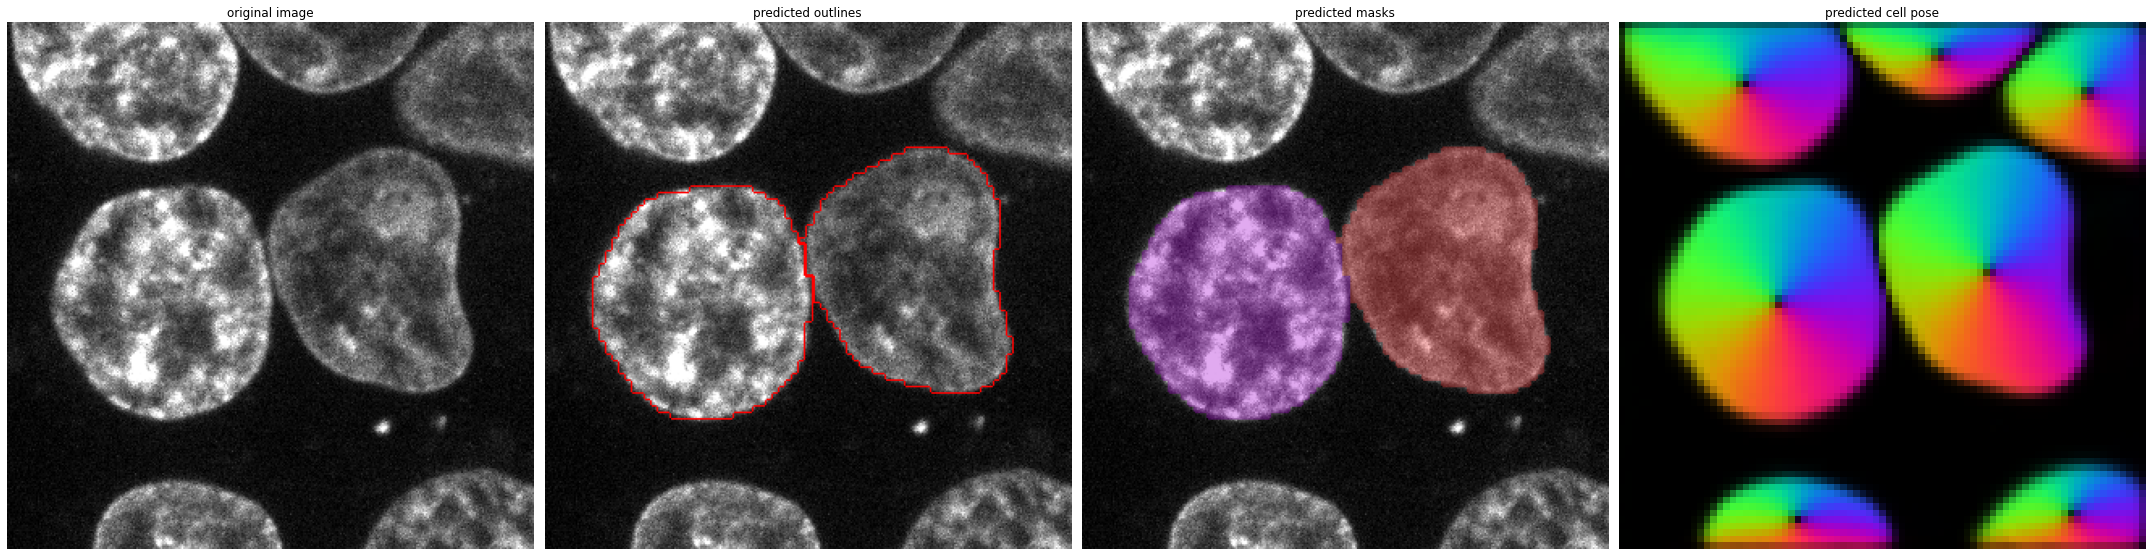

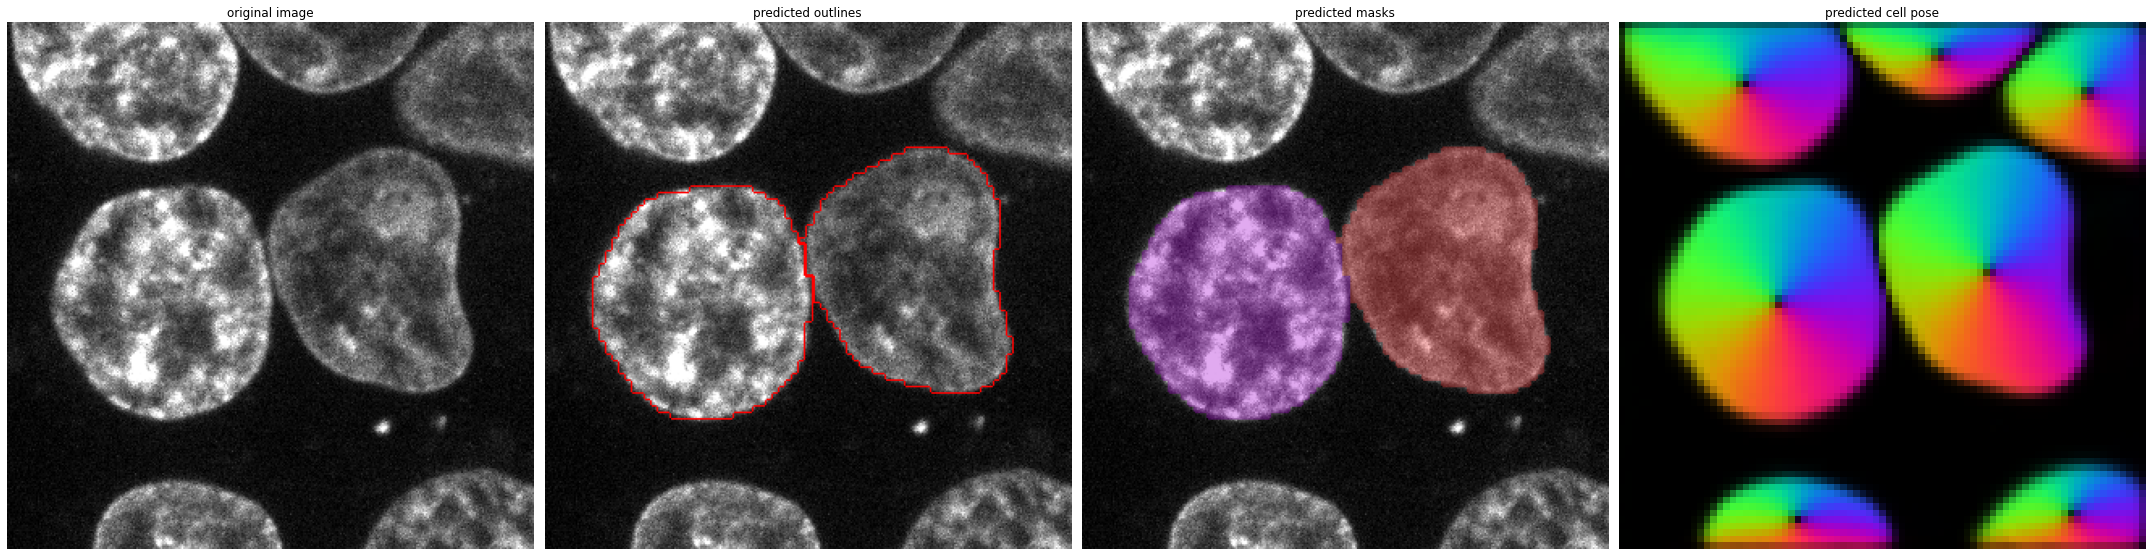

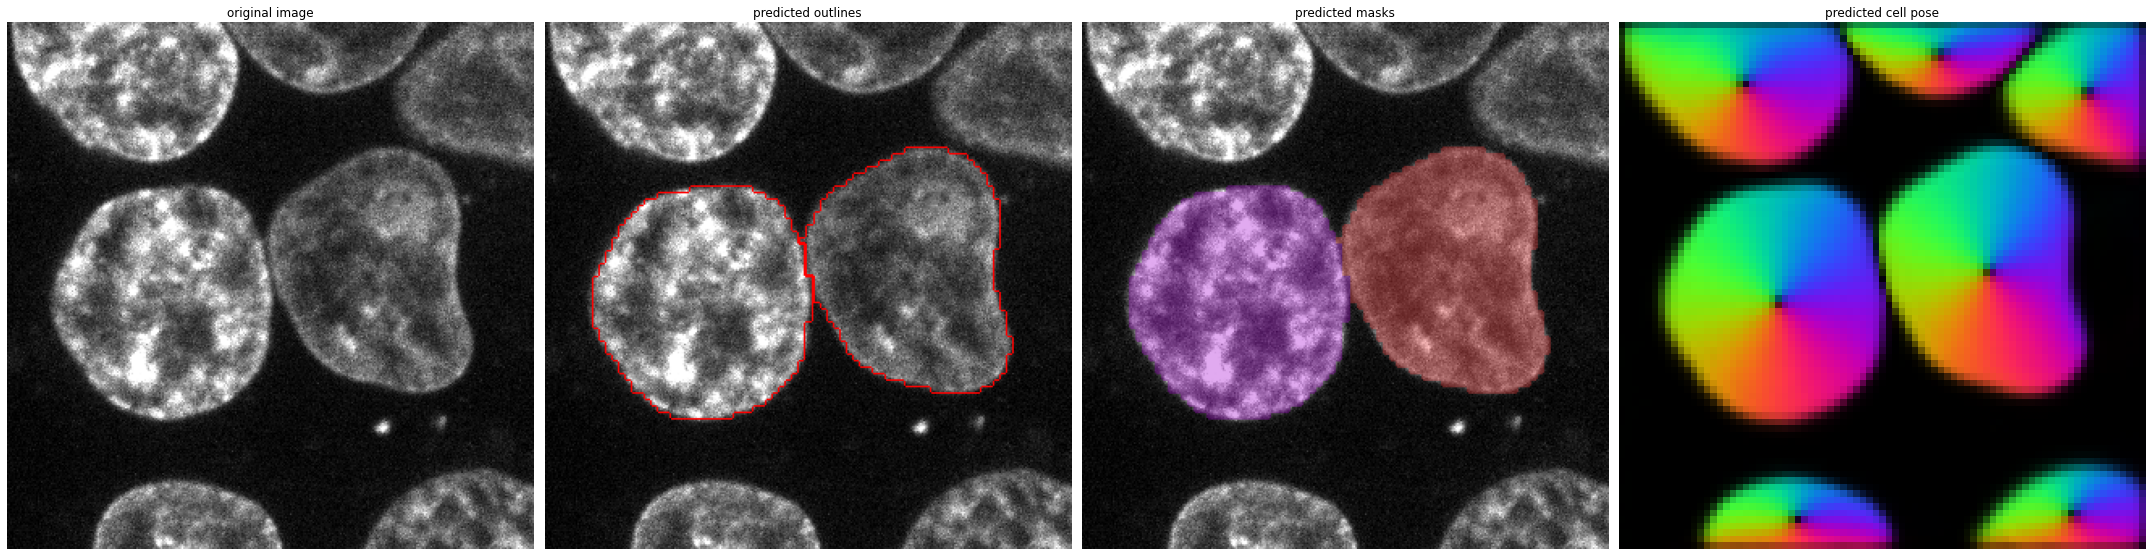

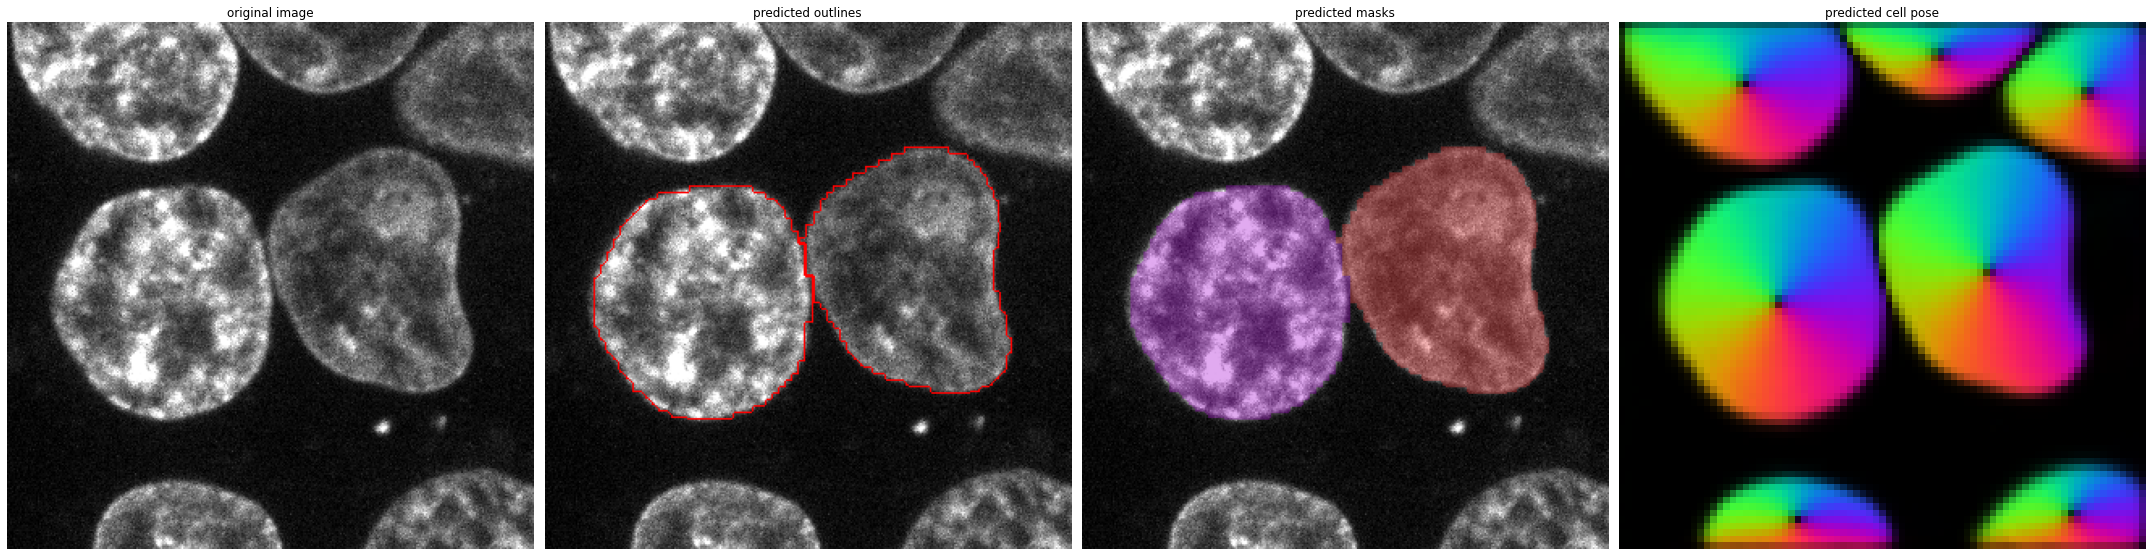

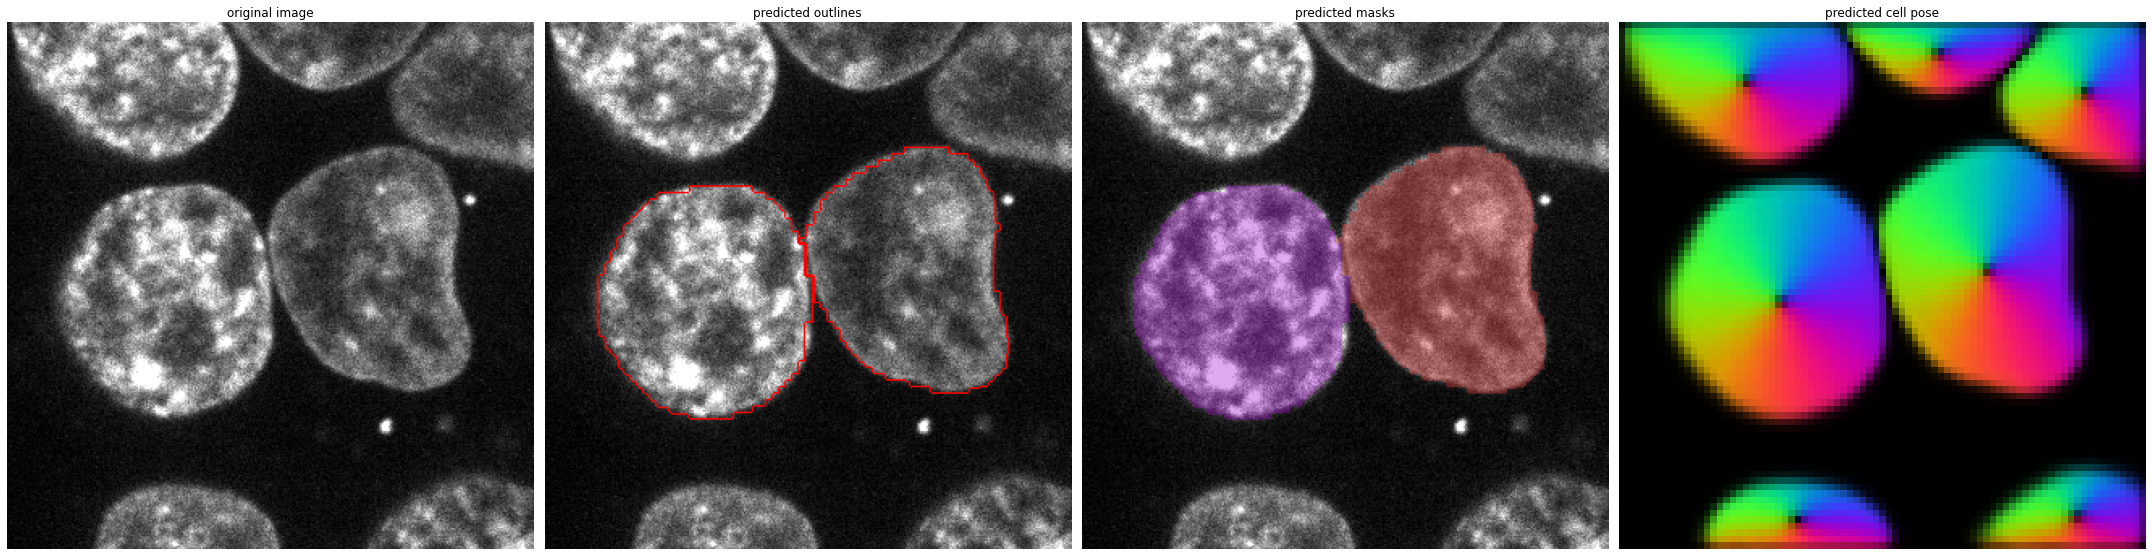

In [9]:
#################################
#  Don't modify the code below  #
#################################

masks, flows, styles, diams = segment_cells(dataset, channel, do_3D=do_3D, model_type=model_type,
                                            diameter=diameter, remove_small_mode=remove_small_mode,
                                            remove_small_diam_fraction=remove_small_diam_fraction,
                                            clear_border=clear_border, gpu=gpu,
                                            flow_threshold=flow_threshold, 
                                            cellprob_threshold=cellprob_threshold,
                                            return_cellpose_debug=True)

#display the results
if 'c' in dataset.dims:
    imgs = dataset.loc[dict(c=chnames[channel])]['image'].data
else:
    imgs = dataset['image'].data

if 'z' not in dataset.dims:
    imgs = [imgs]
    masks = [masks]
    
for i in range(min(5, len(imgs))):
    maski = masks[i]
    flowi = flows[i][0]
    img = imgs[i]
    fig = plt.figure(figsize=(30,10))
    if len(img.shape) > 2:
        img = img[int(img.shape[0]/2)]
        maski = maski[int(maski.shape[0]/2)]
        flowi = flowi[int(flowi.shape[0]/2)]
    plot.show_segmentation(fig, img, maski, flowi, channels=[0,0])
    plt.tight_layout()
    plt.show()

<hr style="height:2px;">

## Run the full processing

The parameters set up in this notebook will be used to segment images in batch.

<hr style="height:2px;">

### Please provide the file name to save the parameters

Default is `parameters.json`

In [10]:
parameter_file = 'parameters.json'

### The following code saves the parameters

To run the full processing, run the notebook [run_cell_segmentation.ipynb](run_cell_segmentation.ipynb) with the parameter values identified here.

In [11]:
#################################
#  Don't modify the code below  #
#################################

params = dict(
    converted_data_dir=os.path.realpath(input_dir),
    cell_segmentation_dir=os.path.realpath(output_dir),
    cells_channel=channel,
    diameter=diameter,
    model_type=model_type, 
    do_3D=do_3D,
    remove_small_mode=remove_small_mode,
    remove_small_diam_fraction=remove_small_diam_fraction,
    flow_threshold=flow_threshold,
    cellprob_threshold=cellprob_threshold,
    gpu=gpu
)
params = save_parameters(params, parameter_file)
    
params

{'converted_data_dir': '/tmp/pycharm_project_989/example_data/stacks',
 'cell_segmentation_dir': '/tmp/pycharm_project_989/test_output/cells',
 'cells_channel': 0,
 'diameter': 120,
 'model_type': 'cyto',
 'do_3D': False,
 'remove_small_mode': '2D',
 'remove_small_diam_fraction': 0.5,
 'flow_threshold': 0.4,
 'cellprob_threshold': 0,
 'gpu': True}